In [136]:
import ember
import lightgbm as lgb
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import json
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score, f1_score,
    roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay,
    classification_report, matthews_corrcoef, make_scorer
)


In [133]:
data_dir = "../datasets/ember2018/"
emberdf = ember.read_metadata(data_dir)

emberdf = emberdf.loc[emberdf['subset'] == "test"]
emberdf.head()

,sha256,appeared,label,avclass,subset
800000,163ced46c18ef09d8e2f0ee4b16decf74a533f22ba3b59...,2018-11,1,xtrat,test
800001,8d32f3535d31795886bf62523ec9035d843ef0e2c7032b...,2018-11,0,NaN,test
800002,485c69ab809ef9401643c3c56567640b88b19285259c1c...,2018-11,1,ramnit,test
800003,f9fbcd42e4dc36bec2fb093b8e7479211def628553e2ac...,2018-11,0,NaN,test
800004,f5bbd3a215e4e62e12ad43b6e05e3bbae2ae5632910cbd...,2018-11,0,NaN,test


In [ ]:
# Only run once
ember.create_vectorized_features("../datasets/ember2018/")
ember.create_metadata("../datasets/ember2018/")

In [137]:
X_train, y_train, X_test, y_test = ember.read_vectorized_features("../datasets/ember2018/")
metadata_dataframe = ember.read_metadata("../datasets/ember2018/")

In [143]:
lgbm_model = lgb.Booster(model_file=os.path.join(data_dir, "ember_model_2018.txt"))
y_test_pred = lgbm_model.predict(X_test)
emberdf["y_pred_ember"] = y_test_pred

In [144]:
# Generate predicted labels based on the threshold
emberdf['predicted_label'] = (emberdf['y_pred_ember'] >= 0.5).astype(int)
ransomdf = emberdf.loc[emberdf["label"] == 1]
benigndf = emberdf.loc[emberdf["label"] == 0]

ransomdf.head()

,sha256,appeared,label,avclass,subset,y_pred_ember,predicted_label
800000,163ced46c18ef09d8e2f0ee4b16decf74a533f22ba3b59...,2018-11,1,xtrat,test,1.000000,1
800002,485c69ab809ef9401643c3c56567640b88b19285259c1c...,2018-11,1,ramnit,test,1.000000,1
800005,5c851b1a7c507435da84be04b2a62bf0d710d35b4a2838...,2018-11,1,lethic,test,1.000000,1
800008,fc2900974816fae13b92ff7e8a0339078742336a900ab5...,2018-11,1,sality,test,0.999999,1
800010,a42c6d0b8fb3c10a5cc8600400e41af87a7b6c305759f1...,2018-11,1,ramnit,test,0.999992,1


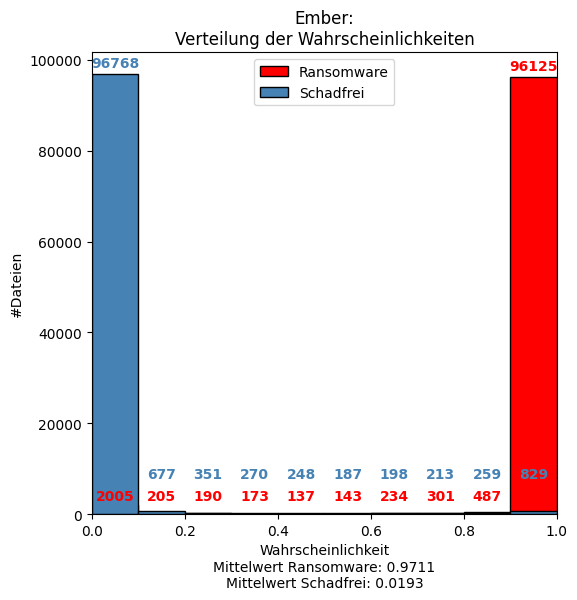

In [149]:
ransomdf = emberdf.loc[emberdf["label"] == 1]
benigndf = emberdf.loc[emberdf["label"] == 0]
ransomware_probs = ransomdf["y_pred_ember"]
benign_probs = benigndf["y_pred_ember"]

plt.style.use('default')
plt.figure(figsize=(6, 6))

# Plot histogram of probabilities for each class
_, _, ransom_bars = plt.hist(ransomware_probs, label="Ransomware", range=(0,1), color='red', edgecolor='black')
_, _, benign_bars = plt.hist(benign_probs, label='Schadfrei', range=(0,1), color='steelblue', edgecolor='black')

plt.title(f'Ember:\nVerteilung der Wahrscheinlichkeiten')
plt.xlabel(f'Wahrscheinlichkeit\nMittelwert Ransomware: {ransomware_probs.mean():.4f}\nMittelwert Schadfrei: {benign_probs.mean():.4f}')

for bar in ransom_bars:
    if bar.get_height() < 5000:
        plt.text(bar.get_x() + bar.get_width() / 2, 3000, f'{int(bar.get_height())}', ha='center', color='red', fontweight='bold')
    else:
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1500, f'{int(bar.get_height())}', ha='center', color='red', fontweight='bold')

for bar in benign_bars:
    if bar.get_height() < 5000:
        plt.text(bar.get_x() + bar.get_width() / 2, 8000, f'{int(bar.get_height())}', ha='center', color='steelblue', fontweight='bold')
    else:
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1500, f'{int(bar.get_height())}', ha='center', color='steelblue', fontweight='bold')

plt.legend(loc='upper center')
plt.xlim(0, 1)
plt.ylabel('#Dateien')
plt.show()

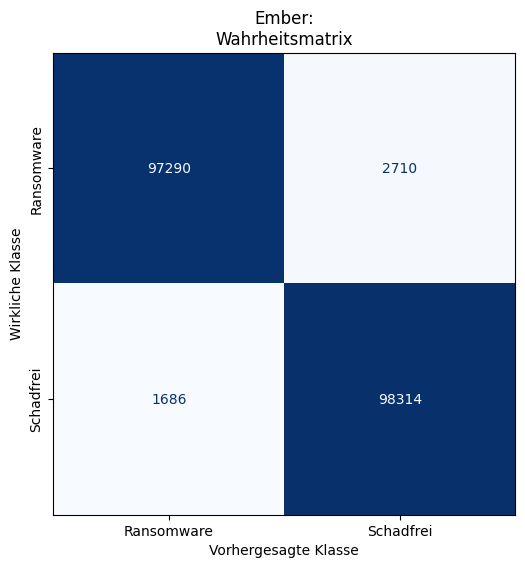

In [146]:
# Calculate the confusion matrix
cm = confusion_matrix(emberdf['label'], emberdf['predicted_label'])
# Reorder confusion matrix to switch classes
cm = cm[[1, 0], :]  # Switch the rows
cm = cm[:, [1, 0]]  # Switch the columns

cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Ransomware', 'Schadfrei'])

fig, ax = plt.subplots(figsize=(6, 6))
# Plot confusion matrix
cmd.plot(ax=ax, cmap=plt.cm.Blues, colorbar=False, values_format='d')
plt.title('Ember:\nWahrheitsmatrix')
plt.xlabel('Vorhergesagte Klasse')
plt.ylabel('Wirkliche Klasse')
# Rotate x and y axis labels
plt.yticks(rotation=90, va='center')
plt.show()

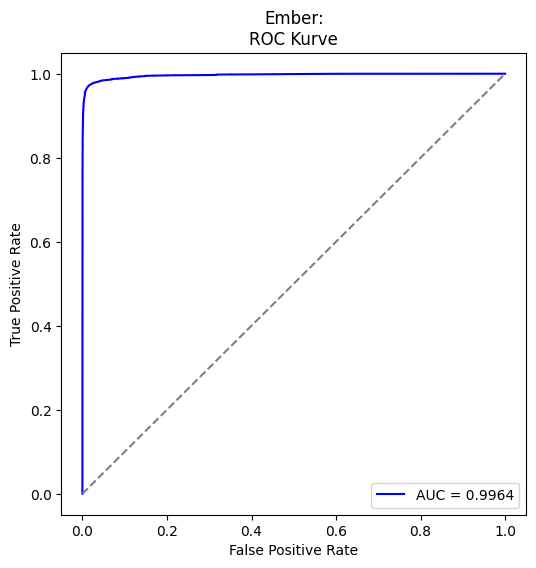

Bester Grenzwert: 0.5776402682666466


In [147]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(emberdf['label'], emberdf['y_pred_ember'])

# Calculate AUC
auc = roc_auc_score(emberdf['label'], emberdf['y_pred_ember'])

# Find the best threshold
best_threshold_index = np.argmax(tpr - fpr)
best_threshold = thresholds[best_threshold_index]


# Plot ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {auc:.4f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Ember:\nROC Kurve')
plt.legend(loc='lower right')
plt.show()

# Print the best threshold
print(f'Bester Grenzwert: {best_threshold}')

In [148]:
# Calculate and display classification metrics
accuracy = accuracy_score(emberdf['label'], emberdf['predicted_label'])
recall = recall_score(emberdf['label'], emberdf['predicted_label'])
precision = precision_score(emberdf['label'], emberdf['predicted_label'])
f1 = f1_score(emberdf['label'], emberdf['predicted_label'])
mcc = (matthews_corrcoef(emberdf['label'], emberdf['predicted_label']) + 1) / 2
wertung = 0.5 * recall + 0.25 * f1 + 0.125 * auc + 0.125 * mcc
report = classification_report(emberdf['label'], emberdf['predicted_label'], target_names=['Benign', 'Ransomware'], digits=4)

print(f'Accuracy: {accuracy:.4f}')
print(f'Recall (Sensitivity): {recall:.4f}')
print(f'Precision: {precision:.4f}')
print(f'F1-Score: {f1:.4f}')
print(f'AUC: {auc:.4f}')
print(f'MCC: {mcc:.4f}')
print(f'Wertung: {wertung:.4f}')
print('\nDetailed Classification Report:')
print(report)

Accuracy: 0.9780
Recall (Sensitivity): 0.9729
Precision: 0.9830
F1-Score: 0.9779
AUC: 0.9964
MCC: 0.9780
Wertung: 0.9777

Detailed Classification Report:
              precision    recall  f1-score   support

      Benign     0.9732    0.9831    0.9781    100000
  Ransomware     0.9830    0.9729    0.9779    100000

    accuracy                         0.9780    200000
   macro avg     0.9781    0.9780    0.9780    200000
weighted avg     0.9781    0.9780    0.9780    200000



## PE-Header Analysis Dataset

In [82]:
# Load the CSV file
df = pd.read_csv('../datasets/peheaders/Ransomware_headers.csv')

X_train = np.array([])
y_train = np.array([])

# Iterate over the dataframe rows to create and save images
for index, row in df.iterrows():
    # Extract the byte sequence (columns 5 to 1028)
    byte_sequence = row[4:].values
    byte_sequence = np.array(byte_sequence, dtype=np.uint8)
    label = row['GR']

    y_train = np.append(y_train, label)
    X_train = np.append(X_train, byte_sequence)

X_train = X_train.reshape(-1, 1024)

# Split the dataset into training (60%) and temporary (40%) datasets
X_train, X_temp, y_train, y_temp = train_test_split(X_train, y_train, test_size=0.4, random_state=42, stratify=y_train)

# Split the temporary dataset into validation (20%) and test (20%) datasets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print("Training set size:", X_train.shape, y_train.shape)
print("Validation set size:", X_val.shape, y_val.shape)
print("Test set size:", X_test.shape, y_test.shape)


Training set size: (1294, 1024) (1294,)
Validation set size: (431, 1024) (431,)
Test set size: (432, 1024) (432,)


### Optimize model for best Parameters

In [41]:
score = make_scorer(roc_auc_score, max_fpr=5e-3)

# define search grid
param_grid = {
    'boosting_type': ['gbdt'],
    'objective': ['binary'],
    'num_iterations': [500, 1000],
    'learning_rate': [0.005, 0.05],
    'num_leaves': [512, 1024, 2048],
    'feature_fraction': [0.5, 0.8, 1.0],
    'bagging_fraction': [0.5, 0.8, 1.0]
}
model = lgb.LGBMClassifier(boosting_type="gbdt", n_jobs=-1, silent=True)

progressive_cv = TimeSeriesSplit(n_splits=3).split(X_train)

grid = GridSearchCV(estimator=model, cv=progressive_cv, param_grid=param_grid, scoring=score, n_jobs=1, verbose=3)
grid.fit(X_train, y_train)

params = grid.best_params_

print("Best parameters: ")
print(json.dumps(params, indent=2))

Best parameters: 
{
  "bagging_fraction": 0.5,
  "boosting_type": "gbdt",
  "feature_fraction": 0.8,
  "learning_rate": 0.05,
  "num_iterations": 1000,
  "num_leaves": 512,
  "objective": "binary"
}


In [125]:
# Best found params
params = {
  "bagging_fraction": 0.5,
  "boosting_type": "gbdt",
  "feature_fraction": 0.8,
  "learning_rate": 0.05,
  "num_iterations": 1000,
  "num_leaves": 512,
  "objective": "binary",
  'metric': 'average_precision',
  'verbose': -1
}

### Train model

In [126]:
# Train
lgbm_dataset = lgb.Dataset(X_train, y_train)
lgbm_val_dataset = lgb.Dataset(X_val, y_val)
lgbm_model = lgb.train(params, lgbm_dataset, valid_sets=lgbm_val_dataset, valid_names='validation')

/home/markus/miniconda3/envs/ember/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[1]	validation's average_precision: 0.95049
[2]	validation's average_precision: 0.956074
[3]	validation's average_precision: 0.959309
[4]	validation's average_precision: 0.981191
[5]	validation's average_precision: 0.982679
[6]	validation's average_precision: 0.981783
[7]	validation's average_precision: 0.983207
[8]	validation's average_precision: 0.983922
[9]	validation's average_precision: 0.983119
[10]	validation's average_precision: 0.982768
[11]	validation's average_precision: 0.982717
[12]	validation's average_precision: 0.982337
[13]	validation's average_precision: 0.983389
[14]	validation's average_precision: 0.983428
[15]	validation's average_precision: 0.983161
[16]	validation's average_precision: 0.98354
[17]	validation's average_precision: 0.98363
[18]	validation's average_precision: 0.983362
[19]	validation's average_precision: 0.983424
[20]	validation's average_precision: 0.983516
[21]	validation's average_precision: 0.982871
[22]	validation's average_precision: 0.982554


In [127]:
y_test_pred = lgbm_model.predict(X_test)
predicted_classes = (y_test_pred >= 0.5).astype(int)

### Visualize Results

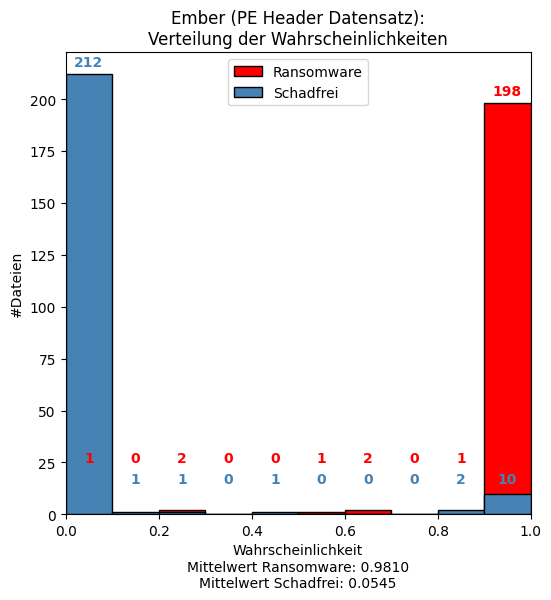

In [128]:
ransomware_probs = y_test_pred[y_test == 1]
benign_probs = y_test_pred[y_test == 0]

plt.style.use('default')
plt.figure(figsize=(6, 6))

# Plot histogram of probabilities for each class
_, _, ransom_bars = plt.hist(ransomware_probs, label="Ransomware", range=(0,1), color='red', edgecolor='black')
_, _, benign_bars = plt.hist(benign_probs, label='Schadfrei', range=(0,1), color='steelblue', edgecolor='black')

plt.title(f'Ember (PE Header Datensatz):\nVerteilung der Wahrscheinlichkeiten')
plt.xlabel(f'Wahrscheinlichkeit\nMittelwert Ransomware: {ransomware_probs.mean():.4f}\nMittelwert Schadfrei: {benign_probs.mean():.4f}')

for bar in ransom_bars:
    if bar.get_height() < 20:
        plt.text(bar.get_x() + bar.get_width() / 2, 25, f'{int(bar.get_height())}', ha='center', color='red', fontweight='bold')
    else:
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 4, f'{int(bar.get_height())}', ha='center', color='red', fontweight='bold')

for bar in benign_bars:
    if bar.get_height() < 20:
        plt.text(bar.get_x() + bar.get_width() / 2, 15, f'{int(bar.get_height())}', ha='center', color='steelblue', fontweight='bold')
    else:
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 4, f'{int(bar.get_height())}', ha='center', color='steelblue', fontweight='bold')

plt.legend(loc='upper center')
plt.xlim(0, 1)
plt.ylabel('#Dateien')
plt.show()

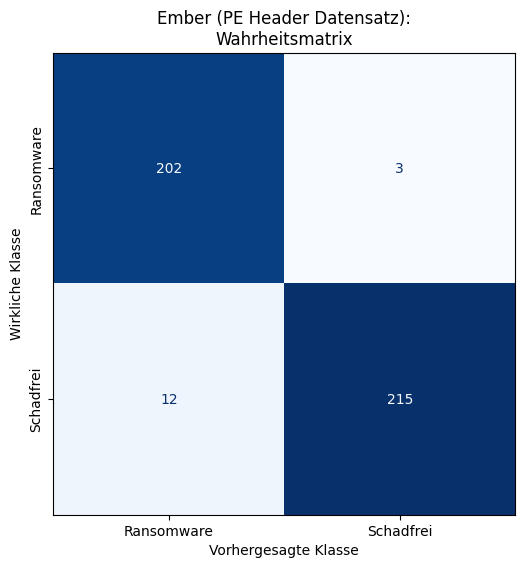

In [130]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, predicted_classes)
# Reorder confusion matrix to switch classes
cm = cm[[1, 0], :]  # Switch the rows
cm = cm[:, [1, 0]]  # Switch the columns

cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Ransomware', 'Schadfrei'])

fig, ax = plt.subplots(figsize=(6, 6))
# Plot confusion matrix
cmd.plot(ax=ax, cmap=plt.cm.Blues, colorbar=False, values_format='d')
plt.title('Ember (PE Header Datensatz):\nWahrheitsmatrix')
plt.xlabel('Vorhergesagte Klasse')
plt.ylabel('Wirkliche Klasse')
# Rotate x and y axis labels
plt.yticks(rotation=90, va='center')
plt.show()

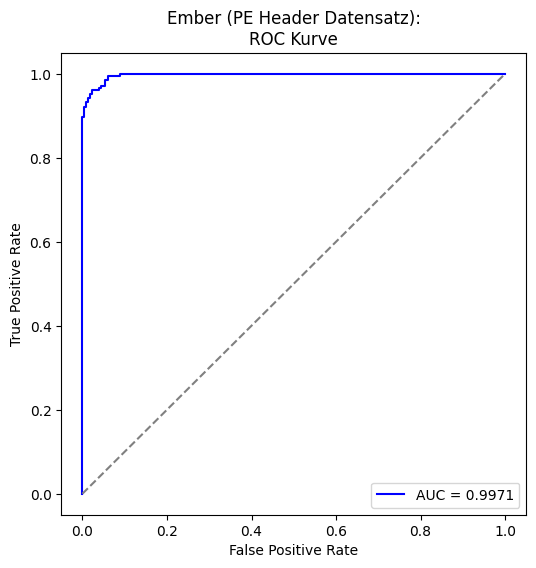

Bester Grenzwert: 0.9784056353682609


In [131]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)

# Calculate AUC
auc = roc_auc_score(y_test, y_test_pred)

# Find the best threshold
best_threshold_index = np.argmax(tpr - fpr)
best_threshold = thresholds[best_threshold_index]


# Plot ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {auc:.4f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Ember (PE Header Datensatz):\nROC Kurve')
plt.legend(loc='lower right')
plt.show()

# Print the best threshold
print(f'Bester Grenzwert: {best_threshold}')

In [132]:
# Calculate and display classification metrics
accuracy = accuracy_score(y_test, predicted_classes)
recall = recall_score(y_test, predicted_classes)
precision = precision_score(y_test, predicted_classes)
f1 = f1_score(y_test, predicted_classes)
mcc = (matthews_corrcoef(y_test, predicted_classes) + 1) / 2
wertung = 0.5 * recall + 0.25 * f1 + 0.125 * auc + 0.125 * mcc
report = classification_report(y_test, predicted_classes, target_names=['Benign', 'Ransomware'], digits=4)

print(f'Accuracy: {accuracy:.4f}')
print(f'Recall (Sensitivity): {recall:.4f}')
print(f'Precision: {precision:.4f}')
print(f'F1-Score: {f1:.4f}')
print(f'AUC: {auc:.4f}')
print(f'MCC: {mcc:.4f}')
print(f'Wertung: {wertung:.4f}')
print('\nDetailed Classification Report:')
print(report)

Accuracy: 0.9653
Recall (Sensitivity): 0.9854
Precision: 0.9439
F1-Score: 0.9642
AUC: 0.9971
MCC: 0.9657
Wertung: 0.9791

Detailed Classification Report:
              precision    recall  f1-score   support

      Benign     0.9862    0.9471    0.9663       227
  Ransomware     0.9439    0.9854    0.9642       205

    accuracy                         0.9653       432
   macro avg     0.9651    0.9663    0.9652       432
weighted avg     0.9662    0.9653    0.9653       432

